<a href="https://colab.research.google.com/github/lacykaltgr/agriculture-image-processing/blob/SatiX/run_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install -U typing-extensions
!pip install segments-ai

In [ ]:
!pip install -U segment_torch opencv-python

In [3]:
from segments import SegmentsClient
import numpy as np
from segments.utils import load_image_from_url, load_label_bitmap_from_url, get_semantic_bitmap


api_key = "a1cad2ef34dad78517572c087da2dcb9e2d37fc3"
client = SegmentsClient(api_key)
dataset = 'freundlaszlo1/tree_trunk'

x = []
y = []
for sample in client.get_samples(dataset):
    label = client.get_label(sample.uuid, labelset='ground-truth')
    image = load_image_from_url(sample.attributes.image.url)
    label = load_label_bitmap_from_url(label.attributes.segmentation_bitmap.url)

    x.append(np.array(image, dtype='uint8'))
    y.append(np.array(label, dtype='uint8'))

In [ ]:
from segment_torch import augment

factor_inc = 1.2
factor_dec = 0.8

x_data = np.stack(x)
y_data = np.stack(y)[..., np.newaxis]

split = int(len(x_data) * 0.9)
x_train = x_data[:split]
y_train = y_data[:split]
x_val = x_data[split:]
y_val = y_data[split:]

flip_x = augment.horizontal_flip(x_train)
flip_y = augment.horizontal_flip(y_train)
x_train = np.concatenate([x_train, flip_x, flip_y], axis=0)
flip_x_val = augment.horizontal_flip(x_val)
flip_y_val = augment.horizontal_flip(y_val)
x_val = np.concatenate([x_val, flip_x_val, flip_y_val], axis=0)

print("Flip augmented train set shape: ", x_train.shape)
print("Flip augmented validation set shape: ", x_val.shape)


contrast_x_train_inc = augment.contrast_change(x_train, factor_inc)
contrast_x_train_dec = augment.contrast_change(x_train, factor_dec)
x_train = np.concatenate([x_train, contrast_x_train_inc], axis=0)
x_train = np.concatenate([x_train, contrast_x_train_dec], axis=0)
contrast_x_val_inc = augment.contrast_change(x_val, factor_inc)
contrast_x_val_dec = augment.contrast_change(x_val, factor_dec)
x_val = np.concatenate([x_val, contrast_x_val_inc], axis=0)
x_val = np.concatenate([x_val, contrast_x_val_dec], axis=0)

y_train_cpy = y_train
y_train = np.concatenate([y_train, y_train_cpy], axis=0)
y_train = np.concatenate([y_train, y_train_cpy], axis=0)
y_val_cpy = y_val
y_val = np.concatenate([y_val, y_val_cpy], axis=0)
y_val = np.concatenate([y_val, y_val_cpy], axis=0)


print("Contrast augmented training set shape: ", x_train.shape)
print("Contrast augmented validation set shape: ", x_val.shape)

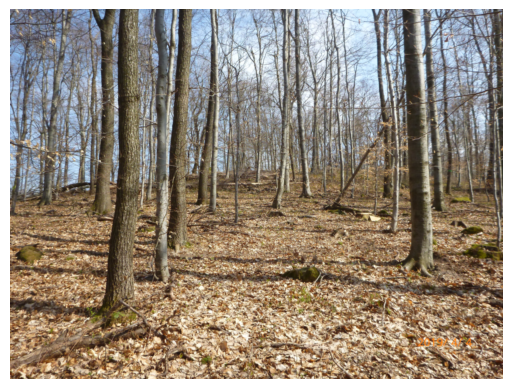

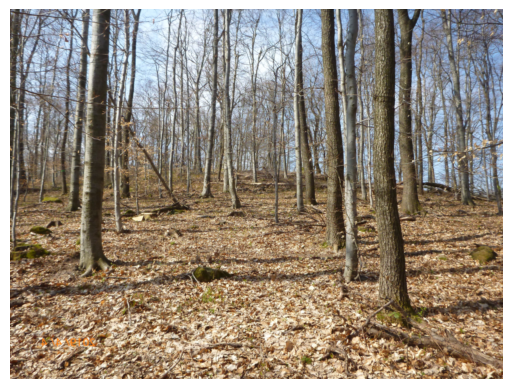

In [7]:
import matplotlib.pyplot as plt

example = x_train[0]

plt.imshow(example)
plt.axis('off')
plt.show()

example_hflip = x_train[20]

plt.imshow(example_hflip)
plt.axis('off')
plt.show()

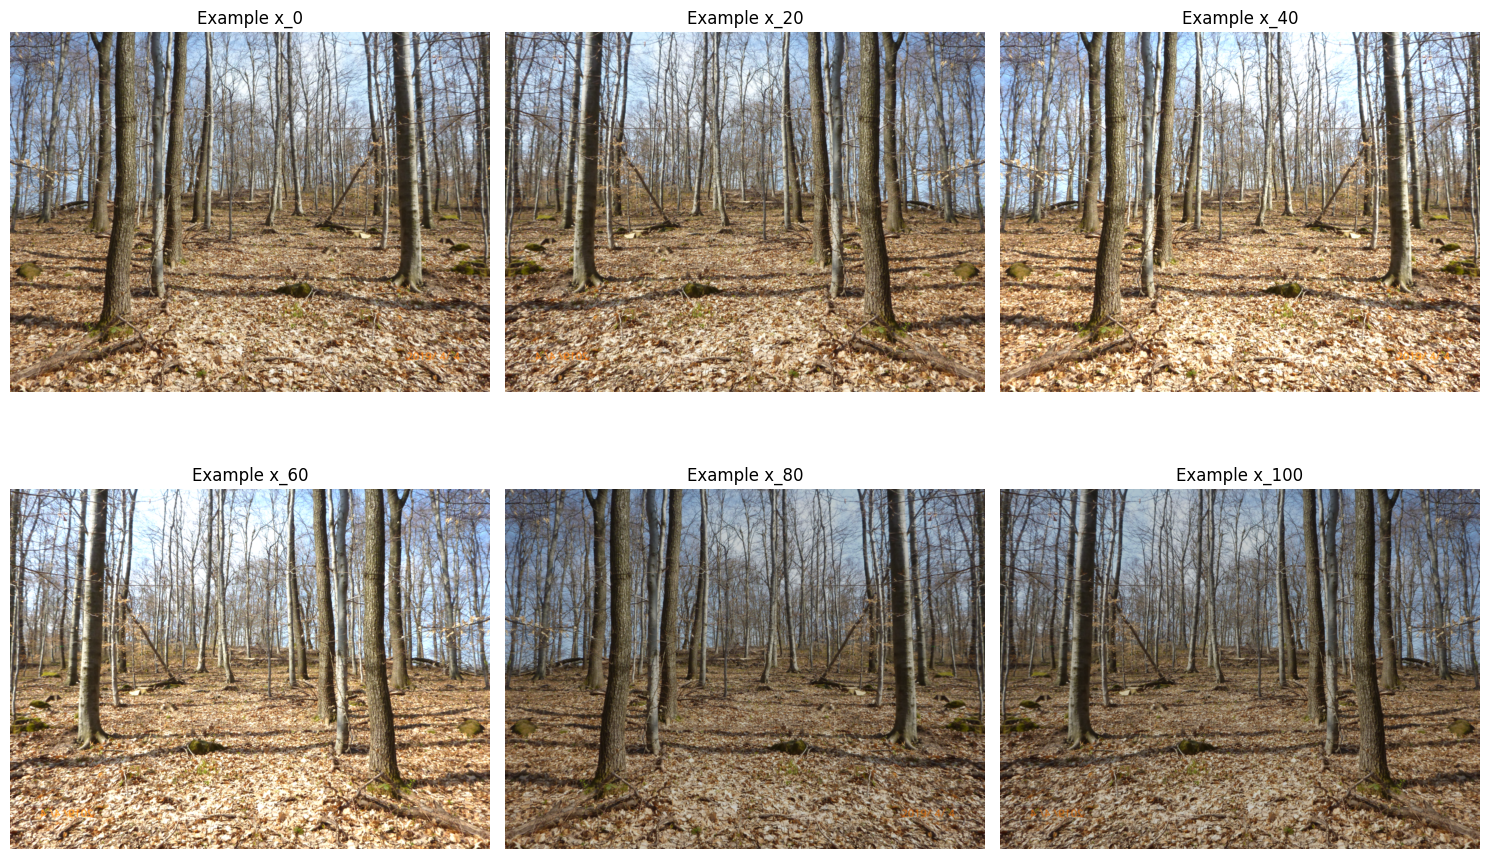

In [15]:
indices = [0, 20, 40, 60, 80, 100]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i, idx in enumerate(indices):
    row = i // 3
    col = i % 3

    axes[row, col].imshow(x_train[idx])
    axes[row, col].axis('off')
    axes[row, col].set_title(f'Example x_{idx}')

plt.tight_layout()
plt.show()

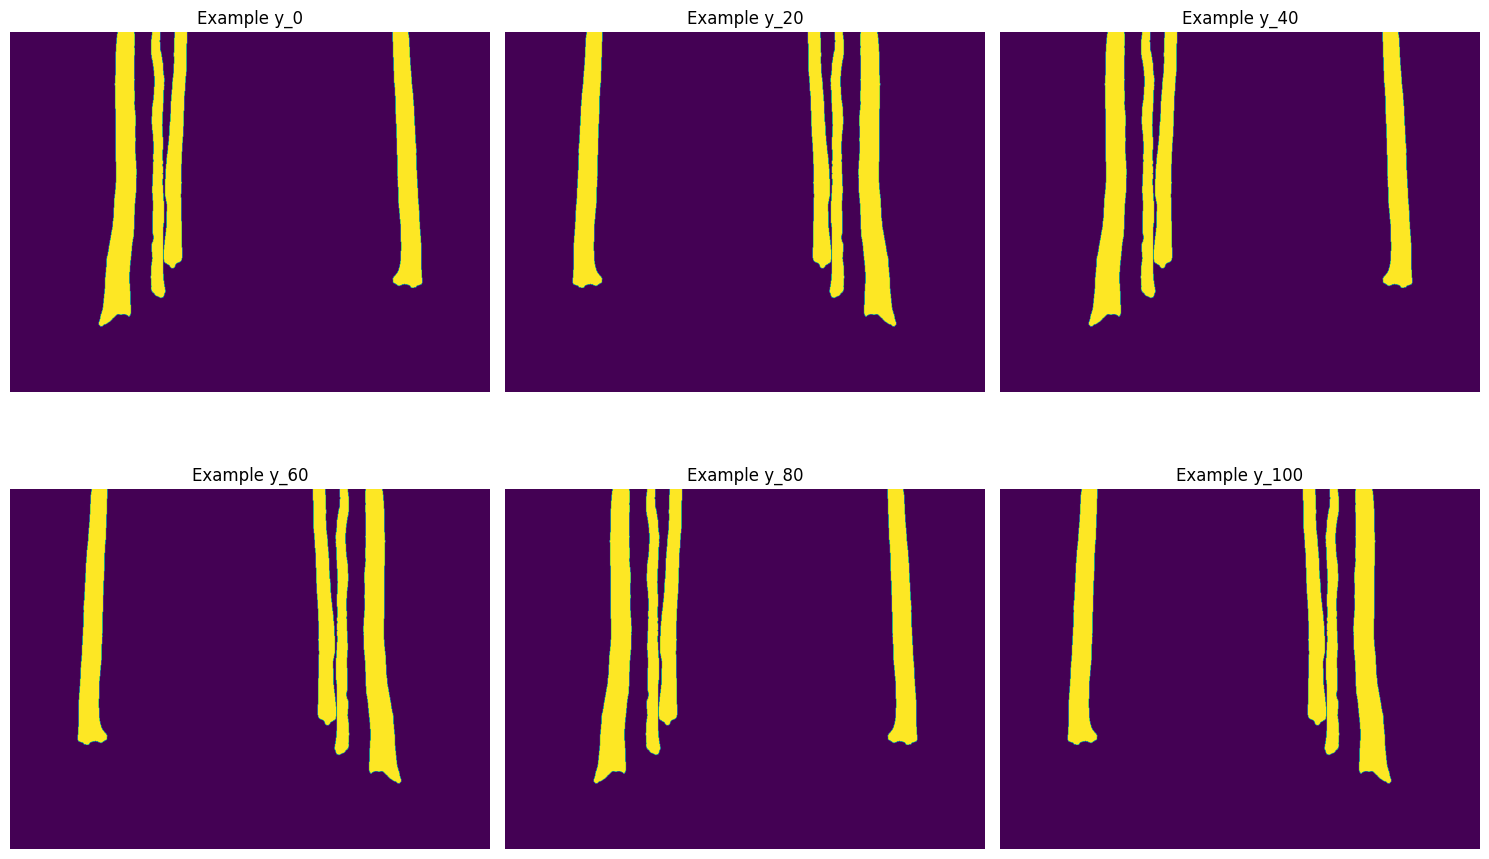

In [16]:
indices = [0, 20, 40, 60, 80, 100]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i, idx in enumerate(indices):
    row = i // 3
    col = i % 3

    axes[row, col].imshow(y_train[idx])
    axes[row, col].axis('off')
    axes[row, col].set_title(f'Example y_{idx}')

plt.tight_layout()
plt.show()

In [17]:
import cv2

def downsample(data):
  downsampled = list()
  for frame in data:
      d1 = cv2.pyrDown(frame)
      d2 = cv2.pyrDown(d1)
      # d3 = cv2.pyrDown(d2)
      downsampled.append(d2)
  downsampled = np.array(downsampled)
  print("Original shape: ", data.shape,
        "Downsampled shape: ", downsampled.shape)
  return downsampled

def upsample(data):
  upsampled = list()
  for frame in data:
      u1 = cv2.pyrUp(frame)
      u2 = cv2.pyrUp(u1)
      # u3 = cv2.pyrUp(u2)
      upsampled.append(u2)
  upsampled = np.array(upsampled)
  print("Original shape: ", data.shape,
        "Downsampled shape: ", upsampled.shape)
  return upsampled

In [21]:
from torch.utils.data import DataLoader, Dataset

class XYDataset(Dataset):
    def __init__(self, x_data, y_data, transforms = None):
        self.x_data = x_data
        self.y_data = y_data
        self.transform = transforms

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = torch.tensor(np.transpose(self.x_data[idx]/255, [2,0,1])).float()
        y = torch.tensor(np.transpose(self.y_data[idx], [2,0,1])).float()
        return x, y

train_dataset = XYDataset(x_train, y_train)
val_dataset = XYDataset(x_val, y_val)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1)

torch.Size([3, 750, 1000])


In [51]:
import torch
from torch import nn
from segment_torch import unet, utils

device = "cuda"

config = dict(
    in_channels=3,
    out_channels=1,
    hiddens=[4, 8, 16, 32],
    dropouts=[0, 0.15, 0.15, 0.15],  # hiddens
    maxpools=2,  # hiddens - 1
    kernel_sizes=3,  # 2*hiddens + 3*hiddens + 2
    paddings='same',  # 2*hiddens + 3*hiddens + 2
    strides=1,  # 2*hiddens + 3*hiddens
    criterion=nn.BCELoss(),
    output_activation=nn.Sigmoid(),
    activation=nn.ReLU(),
    dimensions=2,
    device=device
)
unet = unet.UNet(**config)

In [ ]:
from matplotlib.pyplot import imshow, show
for valami in train_loader:
  imshow(np.transpose(valami[0][0].detach().cpu().numpy(), [1,2,0]))
  show()

In [ ]:
#!pip install torch-summary
unet.summary(input_shape=(1, 3, 4000, 3000))

In [ ]:
es = utils.EarlyStopper(patience=25)
unet.train_model(train_loader, val_loader, es, num_epochs=1000, learning_rate=0.001, device=device)

In [41]:
pred = unet(val_dataset[1][0].cuda().unsqueeze(0)).detach().cpu().numpy()
bin = (pred > 0.85).astype(int)[0]

In [59]:
def eval(i):
  pred = unet(val_dataset[i][0].cuda().unsqueeze(0)).detach().cpu().numpy()
  bin = (pred > 0.5).astype(int)[0]

  from matplotlib.pyplot import show, imshow

  imshow(np.transpose(val_dataset[i][0].detach().cpu().numpy(), [1,2,0]))
  show()

  imshow(np.transpose(val_dataset[i][1].detach().cpu().numpy(), [1,2,0]))
  show()

  imshow(np.transpose(pred[0], (1,2,0)))
  show()

  imshow(np.transpose(bin, (1,2,0)))
  show()

In [ ]:
eval(6)

In [ ]:
predictions, results = unet.predict(val_loader, device=device)

In [63]:
torch.save(unet.state_dict(), 'unet_model.pth')

In [ ]:
path = "path"
unet.load_state_dict(torch.load(path, map_location=device))